In [4]:
import pandas as pd, numpy as np,  seaborn as sns, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import lightgbm as lgb
from xgboost import XGBClassifier



In [5]:
file2 = r"C:\Users\HP\OneDrive\Desktop\BCC_DARKNET_PCA_MODEL\data\MultiTotalDS.csv"
df = pd.read_csv(file2)

In [6]:
drop_cols = ['flow_id','timestamp','src_ip','dst_ip']
df.drop(columns=drop_cols, inplace=True, errors='ignore')

In [7]:
le = LabelEncoder()
df['label'] = le.fit_transform(df['label'])

In [8]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(df.median(numeric_only=True))

In [9]:
X = df.drop('label', axis=1)
y = df['label']

In [10]:
from sklearn.preprocessing import LabelEncoder

# Replace "data" with your dataframe variable
for col in X.select_dtypes(include=['object']).columns:
    print(f"Encoding column: {col}")
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))

Encoding column: protocol
Encoding column: delta_start
Encoding column: handshake_duration


In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [13]:
# Train LightGBM
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=5,   # since you have 5 classes
    boosting_type='gbdt',
    n_estimators=500,
    learning_rate=0.05,
    max_depth=-1,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.043938 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 80845
[LightGBM] [Info] Number of data points in the train set: 6336, number of used features: 451
[LightGBM] [Info] Start training from score -3.925689
[LightGBM] [Info] Start training from score -1.328049
[LightGBM] [Info] Start training from score -1.840266
[LightGBM] [Info] Start training from score -1.336423
[LightGBM] [Info] Start training from score -1.225134
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

LGBMClassifier(colsample_bytree=0.8, learning_rate=0.05, n_estimators=500,
               num_class=5, objective='multiclass', random_state=42,
               subsample=0.8)

In [14]:
y_pred_lgb = lgb_model.predict(X_test)


Accuracy ≈ 96.53%

Classification Report:
              precision    recall  f1-score   support

     FREENET       0.94      0.94      0.94        31
         I2P       0.91      0.98      0.94       420
         TOR       0.96      0.89      0.92       252
         VPN       1.00      1.00      1.00       416
     ZERONET       0.99      0.97      0.98       466

    accuracy                           0.97      1585
   macro avg       0.96      0.95      0.96      1585
weighted avg       0.97      0.97      0.97      1585



Text(50.722222222222214, 0.5, 'Actual')

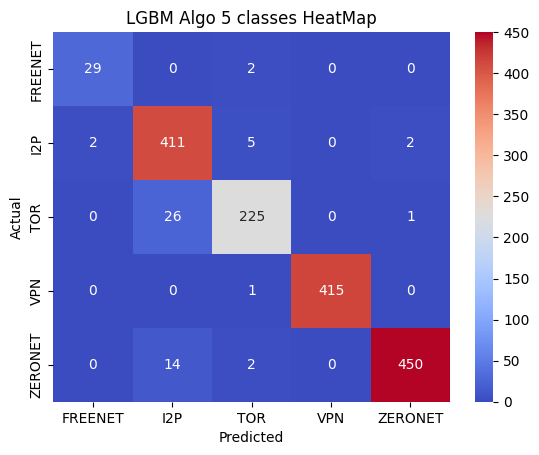

In [15]:
acc = accuracy_score(y_test, y_pred_lgb)
print(f"\nAccuracy ≈ {acc*100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_lgb, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred_lgb)
sns.heatmap(cm, annot=True, fmt='d', cmap='coolwarm', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('LGBM Algo 5 classes HeatMap')
plt.xlabel('Predicted'); plt.ylabel('Actual')

In [28]:
import joblib

joblib.dump(lgb_model, 'model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le, 'encoder.pkl')


['encoder.pkl']

In [20]:
import joblib

data = joblib.load(r"C:\Users\HP\nids_lgbm_pipeline.pkl")
print(data.keys())


dict_keys(['model', 'scaler', 'encoder'])


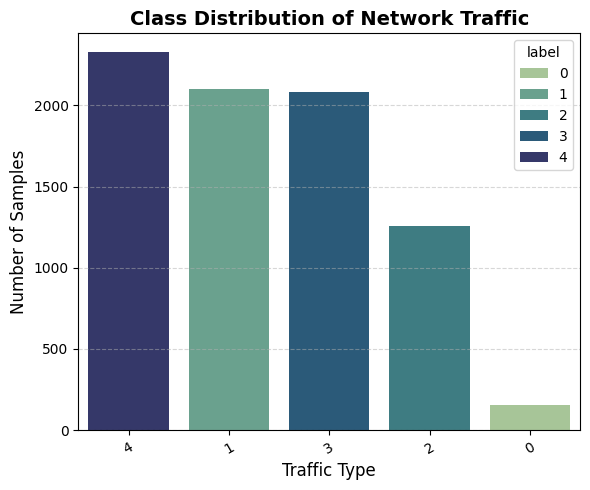

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,5))
sns.countplot(x='label', data=df, palette='crest', hue = 'label', order=df['label'].value_counts().index)
plt.title("Class Distribution of Network Traffic", fontsize=14, weight='bold')
plt.xlabel("Traffic Type", fontsize=12)
plt.ylabel("Number of Samples", fontsize=12)
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


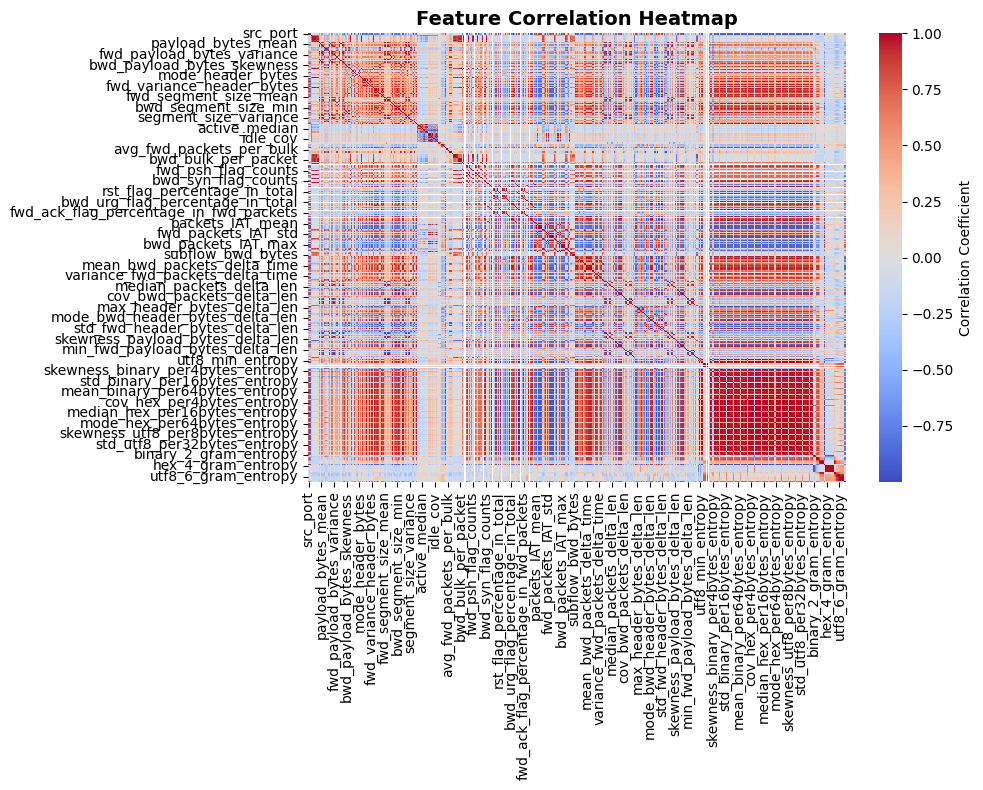

In [22]:
plt.figure(figsize=(10,8))
corr = df.corr(numeric_only=True)
sns.heatmap(corr.corr(), cmap='coolwarm', cbar_kws={'label': 'Correlation Coefficient'})
plt.title("Feature Correlation Heatmap", fontsize=14, weight='bold')
plt.tight_layout()
plt.show()


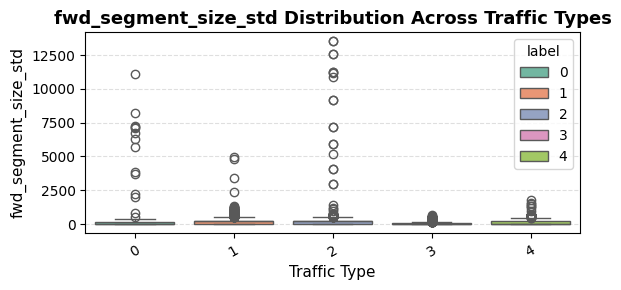

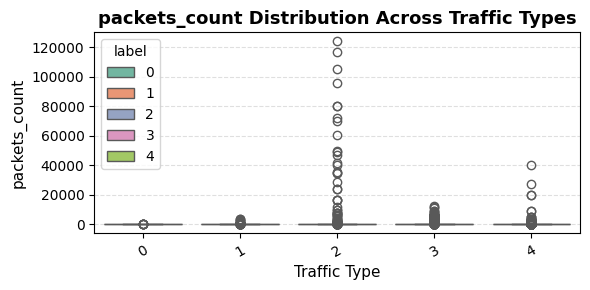

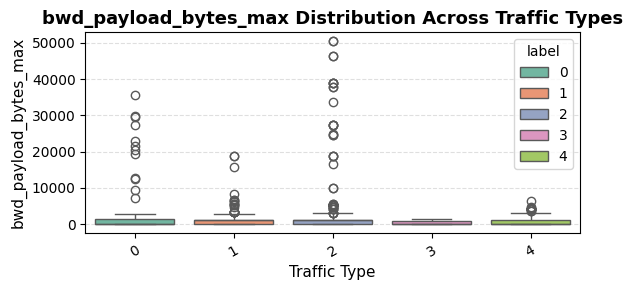

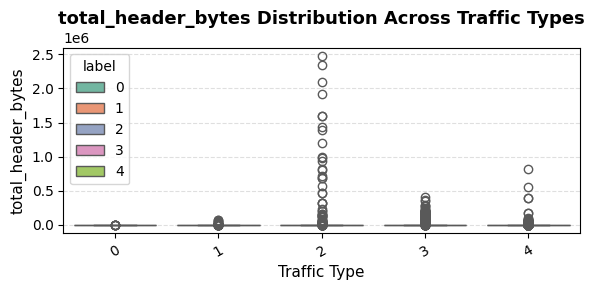

In [23]:
selected_features = ['fwd_segment_size_std', 'packets_count', 'bwd_payload_bytes_max', 'total_header_bytes']
for feature in selected_features:
    plt.figure(figsize=(6,3))
    sns.boxplot(x='label', y=feature, data=df, palette='Set2', hue='label')
    plt.title(f"{feature} Distribution Across Traffic Types", fontsize=13, weight='bold')
    plt.xlabel("Traffic Type", fontsize=11)
    plt.ylabel(feature, fontsize=11)
    plt.xticks(rotation=30)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


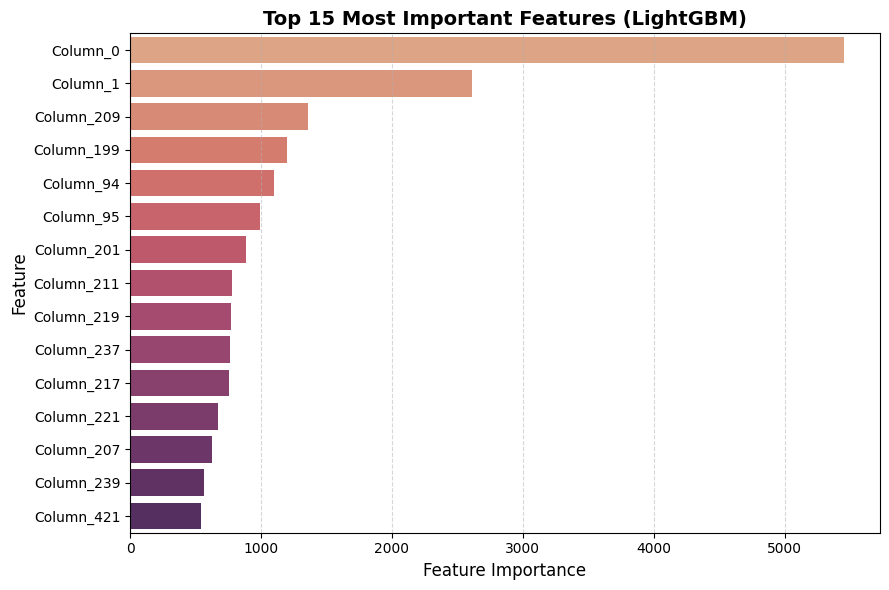

In [24]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

importance_df = pd.DataFrame({
    'Feature': lgb_model.booster_.feature_name(),
    'Importance': lgb_model.feature_importances_
}).sort_values(by='Importance', ascending=False).head(15)

plt.figure(figsize=(9,6))
sns.barplot(y='Feature', x='Importance', data=importance_df, palette='flare',hue='Feature',legend=False)
plt.title("Top 15 Most Important Features (LightGBM)", fontsize=14, weight='bold')
plt.xlabel("Feature Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


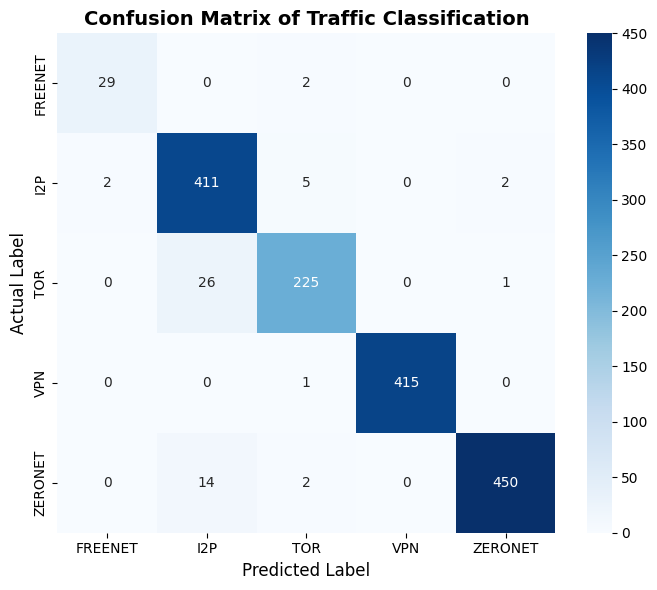

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

y_pred = lgb_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
labels = le.inverse_transform(np.unique(y_test))

plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix of Traffic Classification", fontsize=14, weight='bold')
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("Actual Label", fontsize=12)
plt.tight_layout()
plt.show()


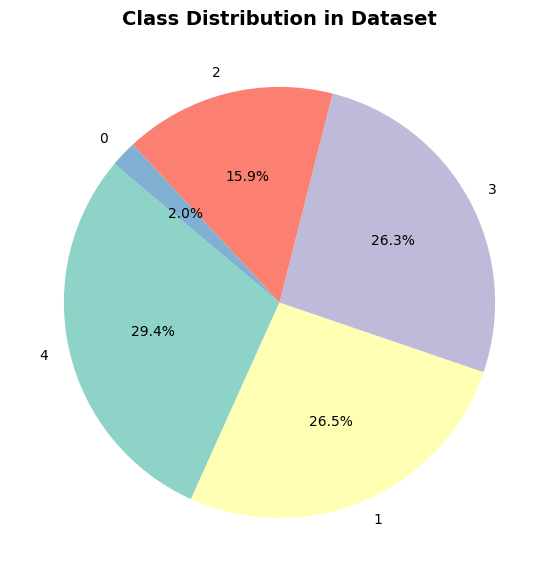

In [26]:
import matplotlib.pyplot as plt

# Assuming 'df' contains your original dataset with 'label' column
label_counts = df['label'].value_counts()

plt.figure(figsize=(7,7))
plt.pie(
    label_counts.values,
    labels=label_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Set3.colors
)
plt.title("Class Distribution in Dataset", fontsize=14, weight='bold')
plt.show()


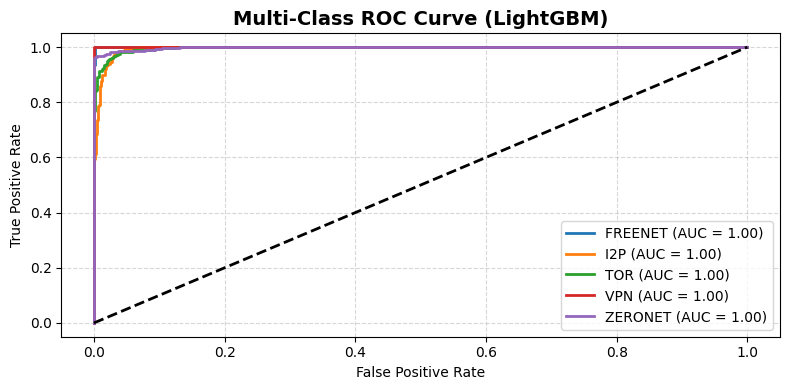

In [27]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import numpy as np

# Binarize labels (convert to one-vs-rest)
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))
y_pred_prob = lgb_model.predict_proba(X_test)

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8,4))

for i, class_label in enumerate(le.classes_):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_prob[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{class_label} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.title("Multi-Class ROC Curve (LightGBM)", fontsize=14, weight='bold')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
